# Udacity Behavior Cloning Project

In [1]:
# Keras model for cloning the driving behavior
# required libraries

%matplotlib inline
import matplotlib.pyplot as plt

import os
import argparse

import numpy as np
import pandas as pd

import cv2
import csv

import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten

Using TensorFlow backend.


# Constants

In [2]:
np.random.seed(0) # Set the random state to 0

# Location of the driving log
data_dir = 'data/mydata/'
driving_log = data_dir +'driving_log.csv'

# Nvidia end to end learning input image spec
rows, cols, ch = 66, 200, 3
nn_input_shape = ((rows, cols, ch))

# Set 20% of the entire dataset as validation
test_split_ratio = 0.2

# Steering angle correction 
# used for left and right camera image
steering_angle_correction_factor = 0.2

# Image Preprocessing

In [3]:
def import_data(driving_log):
    '''
    Create training and validation dataset
    from the driving log
    '''
    samples = []
    with open(driving_log) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            steering_center = float(line[3])
            # create adjusted steering measurements for the side camera images
            correction = 0.2 # this is a parameter to tune
            steering_left = steering_center + correction
            steering_right = steering_center - correction
            
            samples.append(line)
    
    train_samples, validation_samples = train_test_split(samples, test_size=test_split_ratio)
    
    return train_samples, validation_samples

def load_image(img_path):
    """
    Load RGB images from a file
    """
    return mpimg.imread(img_path)

def crop(img):
    '''
    Crop out non-road sections of the image - the top (sky) and the bottom (engine cover)
    '''
    return img[60:-25,:,:]

def resize(img,width=cols,height=rows):
    '''
    Resize the image to the input shape used by the convolution neural network model
    '''
    return cv2.resize(img,(width,height),cv2.INTER_AREA)

def rgb2yuv(img):
    '''
    Convert the RGB image to YUV color space
    Y is the brightness channel
    '''
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def preprocess_image(img):
    img = crop(img)
    img = resize(img)
    img = rgb2yuv(img)
    return img

# Visualize the cropped resized image

(66, 200, 3)


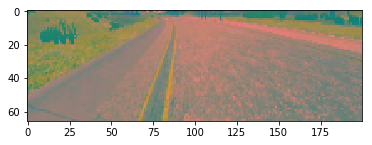

In [5]:
train_samples,validation_samples = import_data(driving_log)
img = load_image(train_samples[0][0])
processed_img = preprocess_image(img)
plt.imshow(processed_img)
print(processed_img.shape)

In [6]:
def modified_NVIDIA_Keras_model(verbose=False):
    '''
    Keras model apoted from Nivida's End to End Learning for Self-Driving Cars paper
    URL: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    '''
    
    model = Sequential()
    
    # Normalization layer 3@66x200
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(66,200,3)))
    
    # 3 layers of 5x5 convolution (output depth 24, 36, and 48) each with 2x2 stride
    model.add(Conv2D(24,kernel_size=5, strides=(2, 2), padding='valid', activation='relu'))
    model.add(Conv2D(36,kernel_size=5, strides=(2, 2), padding='valid', activation='relu'))
    model.add(Conv2D(48,kernel_size=5, strides=(2, 2), padding='valid', activation='relu'))
    
    # 2 layers of 3x3 convolution (output depth 64, and 64)
    
    model.add(Conv2D(64,kernel_size=3, activation='relu'))
    model.add(Conv2D(64,kernel_size=3, activation='relu'))
    
    # Flatten convolution layer
    model.add(Flatten())
    
    # 3 layers of fully connected (depth 100, 50, 10)
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    
    if verbose:
        # Show summary of the layers, output shapes and number of parameters
        model.summary()    

    return model

In [21]:
def batch_generator(samples, batch_size):
    '''
    The custom batch generator divide the data sample in batches and
    applies the image preprocessing (i.e. cropped,resize,RGB2YUV colorspace)
    '''
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # Center image and steering angle
                name = data_dir+'IMG/'+batch_sample[0].split('/')[-1]
                center_image = load_image(name)
                center_image = preprocess_image(center_image)
                center_angle = float(batch_sample[3])
                
                images.append(center_image)
                angles.append(center_angle)
                
                # Left image and steering angle (to be used later for augmentation)
                # name = data_dir+'IMG/'+batch_sample[1].split('/')[-1]
                # left_image = mpimg.imread(name)
                # left_image = preprocess_image(left_image)
                # left_angle = float(batch_sample[3]) + steering_angle_correction_factor

                # Right image and steering angle (to be used later for augmentation)
                # name = data_dir+'IMG/'+batch_sample[2].split('/')[-1]
                # right_image = mpimg.imread(name)
                # right_image = preprocess_image(right_image)
                # right_angle = float(batch_sample[3]) - steering_angle_correction_factor

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

def train_model(model,train_samples,validation_samples,save_model=True):
    '''
    Pipeline to feed the sample data (images and steering angles) in batches,
    train and save the Keras model
    '''
    
    '''
    verbose: Verbosity mode: 0, 1, or 2.
    0 = silent
    1 = progress bar
    2 = one line per epoch
    '''

    # Save the model weights after each epoch if the validation loss decreased
    checkpoint = ModelCheckpoint(filepath='checkpoint/model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    
    # Early Stopping
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=2, 
    #               verbose=1, mode='auto', baseline=None, restore_best_weights=False)
    
    # Log the training progress
    # training log format: epoch, training loss, validation loss
    csv_logger = CSVLogger('log/training.log')

    batch_size = 64
    epochs = 5 #10
    learning_rate = 1e-4
    
    # Compile the Keras model for training to predict the steering angles
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
    
    # Generate the "just in time" data in batches to feed to the model training pipeline
    # model.fit_generator()
    train_generator      = batch_generator(train_samples, batch_size=batch_size)
    validation_generator = batch_generator(validation_samples, batch_size=batch_size)
    
    # Train the model with the generated batched data
    training_history = model.fit_generator(train_generator,
                        steps_per_epoch = len(train_samples)//batch_size,
                        validation_data =  validation_generator,
                        validation_steps= len(validation_samples)//batch_size,
                        epochs=epochs, verbose=1,
                        max_queue_size=1,
                        callbacks=[checkpoint, csv_logger],
                        )
    # print('Test Loss:', model.evaluate_generator(test_gen,steps=128,verbose=1))

    # Save the Keras model for use to predict the steering angles later
    # with the drive.py
    if save_model:
        model.save('model.h5')
    
    return training_history

def plot_training_history(history_object):
    '''
    plot the training and validation loss for each epoch`
    
    '''
    
    print(history_object.history)
    #print(history_object.history.keys())
    
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [22]:
# Import the sample data collected from the Udacity vehicle simulator
train_samples,validation_samples = import_data(driving_log)

# Build the modified Nvidia Keras model
model = modified_NVIDIA_Keras_model()

# Train the Keras model
history_object = train_model(model,train_samples,validation_samples)

Epoch 1/5
90/90 [==============================] - 36s 402ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 2/5
90/90 [==============================] - 26s 293ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 3/5
90/90 [==============================] - 27s 301ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 4/5
90/90 [==============================] - 27s 295ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 5/5
90/90 [==============================] - 26s 293ms/step - loss: 0.0035 - val_loss: 0.0045


{'loss': [0.0083213473282133538, 0.005223993289635632, 0.0043635873938971835, 0.0038579302588670227, 0.0034714701920830955], 'val_loss': [0.0070557165467603636, 0.0054278187665411015, 0.0048349818045442753, 0.0046691845636814833, 0.0044876560462977395]}


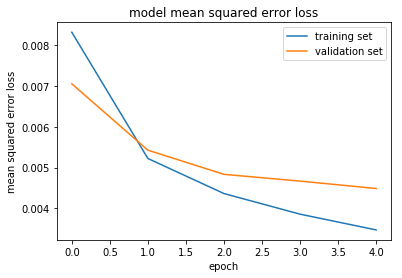

In [23]:
plot_training_history(history_object)

In [11]:
# # Augment data
# def choose_image(data_dir, center, left, right, steering_angle):
#     """
#     Randomly choose an image from the center, left or right, and adjust
#     the steering angle.
#     """
#     choice = np.random.choice(3)
#     if choice == 0:
#         return load_image(data_dir, left), steering_angle + steering_angle_correction_factor
#     elif choice == 1:
#         return load_image(data_dir, right), steering_angle - steering_angle_correction_factor
#     return load_image(data_dir, center), steering_angle

def horizon_flip(img,measurement):
    return np.fliplr(img), -measurement

# def horizon_flip(img,steering_angle):
#     # Horizontal flip image
#     img = cv2.flip(image, 1)
#     # Invert the steering angles to match the horizontal image flip
#     steering_angle = -steering_angle
#     return img, steering_angle

# def random_flip(image, steering_angle):
#     if np.random.rand() < 0.5:
#         return horizon_flip(img,steering_angle)

# def random_translate(img,px=2):
#     height, width = img.shape[:2]
    
#     # Generate random pixels translation in x and y directions
#     fx,fy = np.random.randint(-px,px,2)

#     M = np.float32([[1,0,fx],
#                     [0,1,fy]])
#     translated_img = cv2.warpAffine(img,M,(width,height))    
#     return translated_img

# def random_translate(image, steering_angle, range_x, range_y):
#     trans_x = range_x * (np.random.rand() - 0.5)
#     trans_y = range_y * (np.random.rand() - 0.5)
#     steering_angle += trans_x * 0.002
    
#     trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
#     height, width = image.shape[:2]
#     image = cv2.warpAffine(image, trans_m, (width, height))
#     return image, steering_angle

# def random_brightness(img):
#     # Convert the image in the HSV colorspace, V is the brightness channel
#     img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
#     # Limit the ratio of brightness to +/- 50%
#     new_brightness_ratio = 1.0 + (np.random.rand() - 0.5)
#     img_hsv[:,:,2] =  img_hsv[:,:,2] * new_brightness_ratio
    
#     # Convert the image back to the RGB 
#     return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

# def augument_data(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
#     # Select the simulated camera image out of three positions (left, center, right)
#     #img, steering_angle = choose_image(data_dir, center, left, right, steering_angle)
#     img, steering_angle = random_flip(image, steering_angle)
    
#     # Apply a set of random transforms to image and steering angle 
#     # to generalize the dataset
#     img, steering_angle = random_translate(image, steering_angle, range_x, range_y)
#     img = random_shadow(img)
#     img = random_brightness(img)
    
#     return img, steering_angle

In [ ]:
# # Utility
# def string2bool(string):
#     string = string.lower()
#     return string == 'true' or string == 'yes' or string == 'y' or string == '1'

# def main():
#     parser = argparse.ArgumentParser(description='Behavioral Cloning Training Program')
#     parser.add_argument('-d', help='data directory',        dest='data_dir',          type=str,   default='data')
#     parser.add_argument('-t', help='test size fraction',    dest='test_size',         type=float, default=0.2)
#     parser.add_argument('-k', help='drop out probability',  dest='keep_prob',         type=float, default=0.5)
#     parser.add_argument('-n', help='number of epochs',      dest='nb_epoch',          type=int,   default=10)
#     parser.add_argument('-s', help='samples per epoch',     dest='samples_per_epoch', type=int,   default=20000)
#     parser.add_argument('-b', help='batch size',            dest='batch_size',        type=int,   default=40)
#     parser.add_argument('-o', help='save best models only', dest='save_best_only',    type=string2bool,   default='true')
#     parser.add_argument('-l', help='learning rate',         dest='learning_rate',     type=float, default=1.0e-4)
#     args = parser.parse_args()

#     print('-' * 30)
#     print('Parameters')
#     print('-' * 30)
#     for key, value in vars(args).items():
#         print('{:<20} := {}'.format(key, value))
#     print('-' * 30)

#     data = load_data(args)
#     model = build_model(args)
#     train_model(model, args, *data)

# if __name__ == '__main__':
#     main()

In [ ]:
# def load_datasets(csv_file):
#     # Load the csv data into the Pandas data frame
#     data_df = pd.read_csv(csv_file)
    
#     # Assign the camera images file names as features
#     X = data_df[['center', 'left', 'right']].values
    
#     # Assign the steering angle as labels
#     y = data_df['steering_angle'].values

#     # Split the training and validation data with 80/20 rule
#     X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=test_split_ratio,random_state=0))
#     return X_train, X_valid, y_train, y_valid

In [ ]:
# def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
#     # Generate data (image and steering angle) in batches
#     # to ensure data not exceeding the memory size
#     batch_images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
#     batch_steering = np.empty(batch_size)
    
#     while True:
#         i = 0
#         for index in np.random.permutation(image_paths.shape[0]):
#             center, left, right = image_paths[index]
#             steering_angle = steering_angles[index]
#             # argumentation
#             if is_training and np.random.rand() < 0.6:
#                 image, steering_angle = augument(data_dir, center, left, right, steering_angle)
#             else:
#                 image = load_image(data_dir, center) 
#             # add the image and steering angle to the batch
#             batch_images[i] = preprocess(image)
#             batch_steering[i] = steering_angle
#             i += 1
#             if i == batch_size:
#                 break
#         yield images, steers

In [ ]:
# def random_shadow(img):
#     # (x1, y1) and (x2, y2) forms a line
#     # xm, ym gives all the locations of the image
#     x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
#     x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
#     xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

#     # mathematically speaking, we want to set 1 below the line and zero otherwise
#     # Our coordinate is up side down.  So, the above the line: 
#     # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
#     # as x2 == x1 causes zero-division problem, we'll write it in the below form:
#     # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
#     mask = np.zeros_like(image[:, :, 1])
#     mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

#     # choose which side should have shadow and adjust saturation
#     cond = mask == np.random.randint(2)
#     s_ratio = np.random.uniform(low=0.2, high=0.5)

#     # adjust Saturation in HLS(Hue, Light, Saturation)
#     hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#     hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
#     return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)